# **Blah**

In [ ]:
	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()
   

In [ ]:
	def compute_heatmap(self, image, eps=1e-8):
   
   gradModel = Model(inputs=[self.model.inputs],outputs=[self.model.get_layer(self.layerName).output,self.model.output])
   with tf.GradientTape() as tape:
     inputs = tf.cast(image, tf.float32)
     (convOutputs, predictions) = gradModel(inputs)
     loss = predictions[:, self.classIdx]

   grads = tape.gradient(loss, convOutputs)
   castConvOutputs = tf.cast(convOutputs > 0, "float32")
   castGrads = tf.cast(grads > 0, "float32")
   guidedGrads = castConvOutputs * castGrads * grads
   convOutputs = convOutputs[0]
   guidedGrads = guidedGrads[0]
   weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
   cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
   (w, h) = (image.shape[2], image.shape[1])
   heatmap = cv2.resize(cam.numpy(), (w, h))
   numer = heatmap - np.min(heatmap)
   denom = (heatmap.max() - heatmap.min()) + eps
   heatmap = numer / denom
   heatmap = (heatmap * 255).astype("uint8")

   return heatmap
  

In [ ]:
def overlay_heatmap(self, heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):
  heatmap = cv2.applyColorMap(heatmap, colormap)
  output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
  return (heatmap, output)

In [ ]:
#from pyimagesearch.gradcam import GradCAM
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import argparse
import imutils
import cv2


In [ ]:
!pip install opencv-contrib-python
!pip install scikit-image

In [ ]:
from pyimagesearch.gradcam import GradCAM


ModuleNotFoundError: ignored

In [ ]:
import numpy as np
import cv2

#For images
from keras.preprocessing.image import array_to_img, img_to_array, load_img
#For model loading
from keras.models import load_model
#For Grad-CAM calculation
from tensorflow.keras import models
import tensorflow as tf

In [ ]:
IMAGE_SIZE  = (336, 336)


In [ ]:
def grad_cam(input_model, x, layer_name):
    """
    Args: 
        input_model(object):Model object
        x(ndarray):image
        layer_name(string):The name of the convolution layer
    Returns:
        output_image(ndarray):Colored image of the original image
    """

    #Image preprocessing
    #Since there is only one image to read, mode must be increased..I can't predict
    X = np.expand_dims(x, axis=0)
    preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    #Calculate the gradient
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    #Average the weights and multiply by the output of the layer
    weights = np.mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    #Scale the image to the same size as the original image
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    #Instead of ReLU
    cam  = np.maximum(cam, 0)
    #Calculate heatmap
    heatmap = cam / cam.max()

    #Pseudo-color monochrome images
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    #Convert to RGB
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    #Combined with the original image
    output_image = (np.float32(rgb_cam) + x / 2)  
    
    return output_image


In [ ]:
model_path = '/content/drive/MyDrive/cassava_dense121_run2.h5'
image_path = '/content/drive/MyDrive/Splitted/val/cbb/train-cbb-330.jpg'

model = load_model(model_path)
x = img_to_array(load_img(image_path, target_size=IMAGE_SIZE))

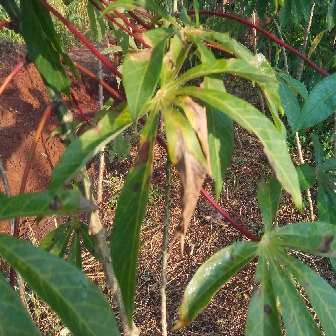

In [ ]:
array_to_img(x)

In [ ]:
target_layer = 'conv2d'
cam = grad_cam(model, x, target_layer)

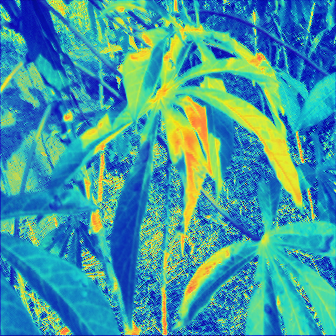

In [ ]:
array_to_img(cam)

# **Grad cam orig code(imagenet weight)**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import tensorflow as tf

import numpy as np
import imutils
import cv2

In [ ]:
model = VGG16(weights="imagenet")

In [ ]:
orig = cv2.imread("/content/drive/MyDrive/butterfly.jpg")
resized = cv2.resize(orig, (224, 224))

In [ ]:
image = load_img("/content/drive/MyDrive/butterfly.jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

In [ ]:
preds = model.predict(image)
i = np.argmax(preds[0])
decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

[INFO] monarch: 99.93%


In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.inputs], outputs= [self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)


In [ ]:
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

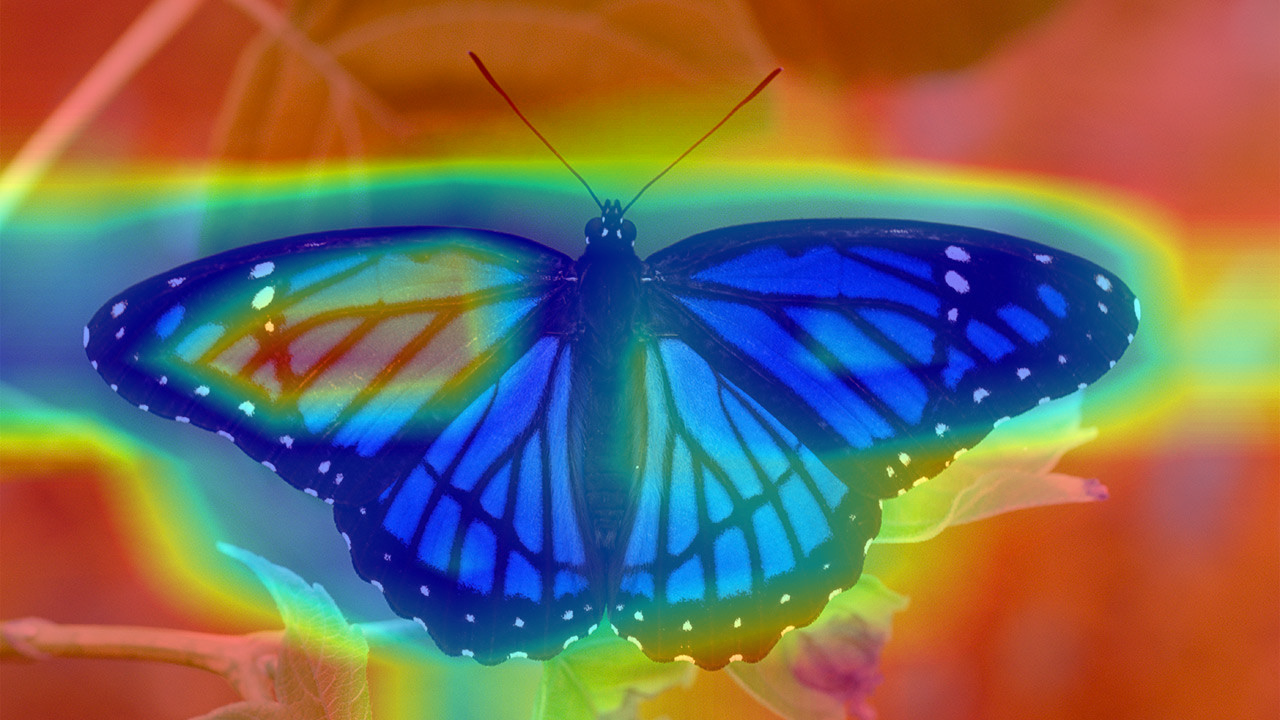

In [ ]:
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
array_to_img(heatmap)
array_to_img(output)

#**Grad-Cam for cassava**

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import tensorflow as tf

import numpy as np
import imutils
import cv2

In [ ]:
#filepath='/content/drive/MyDrive/cassava_dense121_run2.h5'
filepath='/content/drive/MyDrive/cassava_aug_MobileNet.h5'
filepath2='/content/drive/MyDrive/casssava-aug-mobile.h5'
model = keras.models.load_model(filepath2)

In [ ]:

img_path='/content/drive/MyDrive/Augmented_Data/test/test_cbsd/156209433.jpg'
orig = cv2.imread(img_path)
resized = cv2.resize(orig, (336,336))
image1 = load_img(img_path, target_size=(336,336))
image1 = img_to_array(image1)
image1 = np.expand_dims(image1, axis=0)
image1 = imagenet_utils.preprocess_input(image1)




In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
new_img = image.load_img(img_path, target_size=(336, 336))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

In [ ]:
preds = model.predict(image1)
i = np.argmax(preds[0])
print(i)
print(j)

2
0.95677674


In [ ]:
prediction = model.predict(img)
d = prediction.flatten()
j = d.max()
li = ['Cassava Bacterial Blight','Cassava Brown Streak Disease','Cassava Green Mottle','Cassava Mossaic Disease','Healthy']
for index,item in enumerate(d):
  if item == j:
    class_name = li[index]
print(class_name)

Cassava Brown Streak Disease


In [10]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.inputs], outputs= [self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)


In [ ]:
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

ValueError: ignored

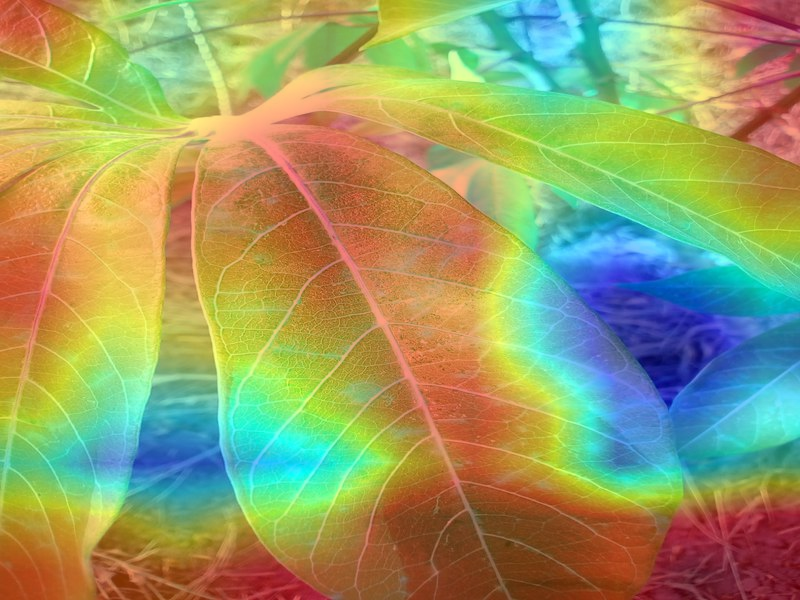

In [ ]:
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
array_to_img(heatmap)
array_to_img(output)

# **mobilenet visualization**

In [2]:
filepath='/content/drive/MyDrive/final models/casssava-aug-mobile.h5'
from tensorflow import keras
model = keras.models.load_model(filepath)

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 336, 336, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 168, 168, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 168, 168, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 168, 168, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [12]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
img_path='/content/drive/MyDrive/Augmented_Data/test/test_healthy/train-healthy-22.jpg'
new_img = image.load_img(img_path, target_size=(336, 336))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

prediction = model.predict(img)
d = prediction.flatten()
j = d.max()
li = ['Cassava Bacterial Blight','Cassava Brown Streak Disease','Cassava Green Mottle','Cassava Mossaic Disease','Healthy']
ind=0
for index,item in enumerate(d):
  if item == j:
    class_name = li[index]
    ind=index
print(class_name)
print(ind)


orig = cv2.imread(img_path)
resized = cv2.resize(orig, (336,336))

Healthy
4


In [13]:
from tensorflow.keras.preprocessing.image import img_to_array,array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import imutils
import cv2

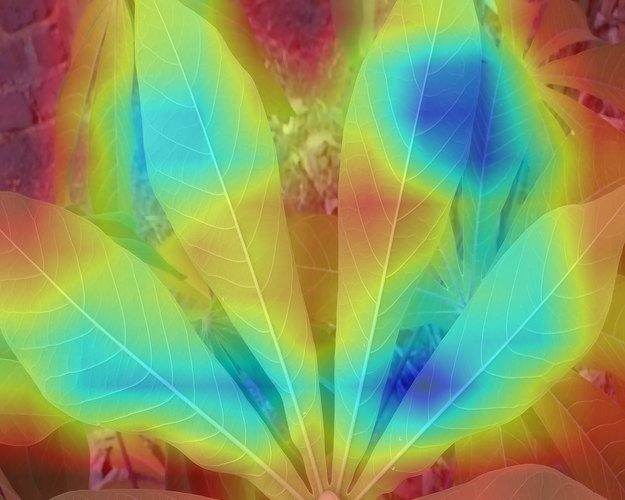

In [16]:
cam = GradCAM(model, ind)
heatmap = cam.compute_heatmap(img)
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
array_to_img(heatmap)
array_to_img(output)

# **resnet visualization**

In [18]:
filepath1='/content/drive/MyDrive/final models/casssava-aug-resnet.h5'
from tensorflow import keras
model1 = keras.models.load_model(filepath1)
model1.summary()
print(type(model1))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 336, 336, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 342, 342, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 168, 168, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 168, 168, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [19]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
img_path='/content/drive/MyDrive/Augmented_Data/test/test_healthy/train-healthy-22.jpg'
new_img = image.load_img(img_path, target_size=(336, 336))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

prediction = model1.predict(img)
d = prediction.flatten()
j = d.max()
li = ['Cassava Bacterial Blight','Cassava Brown Streak Disease','Cassava Green Mottle','Cassava Mossaic Disease','Healthy']
ind=0
for index,item in enumerate(d):
  if item == j:
    class_name = li[index]
    ind=index
print(class_name)
print(ind)

orig = cv2.imread(img_path)
resized = cv2.resize(orig, (336,336))

Healthy
4


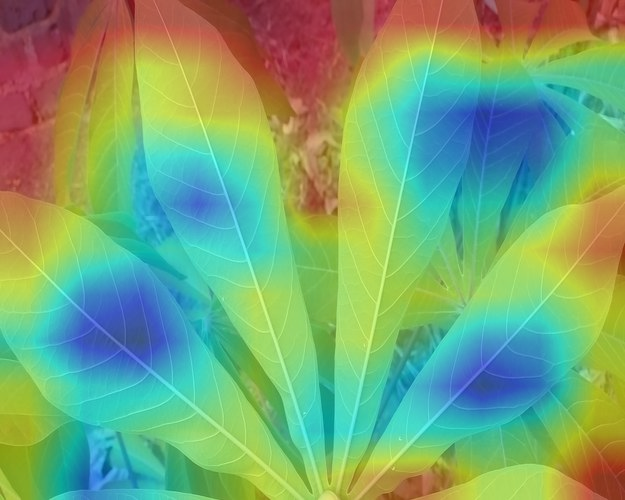

In [20]:
from tensorflow.keras.preprocessing.image import img_to_array,array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import imutils
import cv2
cam = GradCAM(model1, ind)
heatmap = cam.compute_heatmap(img)
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
array_to_img(heatmap)
array_to_img(output)

# **DenseNet121 visualization**

In [ ]:
filepath2='/content/drive/MyDrive/final models/cassava_dense121_run2.h5'
from tensorflow import keras
model2 = keras.models.load_model(filepath2)
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 336, 336, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 336, 336, 3)       84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
img_path='/content/drive/MyDrive/Augmented_Data/test/test_cmd/207069305.jpg'
new_img = image.load_img(img_path, target_size=(336, 336))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

prediction = model1.predict(img)
d = prediction.flatten()
j = d.max()
li = ['Cassava Bacterial Blight','Cassava Brown Streak Disease','Cassava Green Mottle','Cassava Mossaic Disease','Healthy']
ind=0
for index,item in enumerate(d):
  if item == j:
    class_name = li[index]
    ind=index
print(class_name)
print(ind)

orig = cv2.imread(img_path)
resized = cv2.resize(orig, (336,336))

Cassava Mossaic Disease
3


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array,array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import imutils
import cv2
cam = GradCAM(model2, ind)
heatmap = cam.compute_heatmap(img)
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
array_to_img(heatmap)
array_to_img(output)

ValueError: ignored

In [ ]:
print(type(model2))

<class 'tensorflow.python.keras.engine.functional.Functional'>


# **New DenseNet121**

In [ ]:
from keras.applications import DenseNet121
densenet = DenseNet121(weights='imagenet', include_top=True)

In [ ]:
densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2 (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_12[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
from keras.models import Model,Sequential, Input, load_model
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D

img_size=336
input_tensor = Input(shape=(img_size, img_size, 3))

base_model = DenseNet121(weights='imagenet',include_top = False,input_tensor = input_tensor)
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 336, 336, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 342, 342, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 168, 168, 64) 9408        zero_padding2d_14[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 168, 168, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(5,activation='softmax')(x)

dense_model = Model(inputs=base_model.input,outputs=output)
dense_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 336, 336, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 342, 342, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 168, 168, 64) 9408        zero_padding2d_14[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 168, 168, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
#img_size=336
img_size=224
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.0,
    width_shift_range=0.2,
    height_shift_range=0.2)

valid_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Augmented_Data/Splitted/train',  #training data path
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        '/content/drive/MyDrive/Augmented_Data/Splitted/val', #validation data path
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical',
        shuffle = False)

Found 6000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


In [ ]:
from keras.optimizers import Adam,SGD
#optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
optimizer = SGD(lr=1e-5,momentum=0.9)
dense_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
filepath = '/content/drive/MyDrive/cassava-aug-dense121SGD.h5'   #path where the model should be saved
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator,
                   validation_steps = valid_generator.n // valid_generator.batch_size,
                   validation_data = valid_generator,
                   steps_per_epoch = train_generator.n // train_generator.batch_size ,
                   epochs = 39,
                   callbacks = [annealer,checkpoint])

Epoch 1/39
187/187 [==============================] - 3643s 19s/step - loss: 0.5815 - accuracy: 0.7892 - val_loss: 0.8944 - val_accuracy: 0.7398

Epoch 00001: val_loss improved from inf to 0.89436, saving model to /content/drive/MyDrive/cassava-aug-dense121.h5
Epoch 2/39
187/187 [==============================] - 121s 649ms/step - loss: 0.5848 - accuracy: 0.7914 - val_loss: 0.8542 - val_accuracy: 0.7446

Epoch 00002: val_loss improved from 0.89436 to 0.85416, saving model to /content/drive/MyDrive/cassava-aug-dense121.h5
Epoch 3/39
187/187 [==============================] - 121s 647ms/step - loss: 0.5662 - accuracy: 0.7998 - val_loss: 0.8223 - val_accuracy: 0.7439

Epoch 00003: val_loss improved from 0.85416 to 0.82235, saving model to /content/drive/MyDrive/cassava-aug-dense121.h5
Epoch 4/39
187/187 [==============================] - 121s 648ms/step - loss: 0.5641 - accuracy: 0.7966 - val_loss: 0.7892 - val_accuracy: 0.7446

Epoch 00004: val_loss improved from 0.82235 to 0.78918, savi

In [ ]:
history = model.fit(train_generator,
                   validation_steps = valid_generator.n // valid_generator.batch_size,
                   validation_data = valid_generator,
                   steps_per_epoch = train_generator.n // train_generator.batch_size ,
                   epochs = 100,
                   callbacks = [annealer,checkpoint])

Epoch 1/100
187/187 [==============================] - 121s 645ms/step - loss: 0.4550 - accuracy: 0.8393 - val_loss: 0.6495 - val_accuracy: 0.7806

Epoch 00001: val_loss improved from inf to 0.64953, saving model to /content/drive/MyDrive/cassava-aug-dense121SGD.h5
Epoch 2/100
187/187 [==============================] - 121s 645ms/step - loss: 0.4471 - accuracy: 0.8475 - val_loss: 0.6495 - val_accuracy: 0.7826

Epoch 00002: val_loss improved from 0.64953 to 0.64949, saving model to /content/drive/MyDrive/cassava-aug-dense121SGD.h5
Epoch 3/100
187/187 [==============================] - 120s 643ms/step - loss: 0.4380 - accuracy: 0.8510 - val_loss: 0.6424 - val_accuracy: 0.7846

Epoch 00003: val_loss improved from 0.64949 to 0.64241, saving model to /content/drive/MyDrive/cassava-aug-dense121SGD.h5
Epoch 4/100
187/187 [==============================] - 121s 645ms/step - loss: 0.4413 - accuracy: 0.8485 - val_loss: 0.6379 - val_accuracy: 0.7880

Epoch 00004: val_loss improved from 0.64241 to